# Predicting Boston Housing Prices

I got the opportunity to take a look at this dataset as part of the Udacity Machine Learning Nanodegree program. I ended up pulling the original (and more complete) data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing) to present a more complete analysis. 

The idea here is to produce a prediction model for home prices based on the features provided.

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit
%matplotlib inline

from pylab import rcParams
import seaborn as sns
sns.set_style('whitegrid')

rcParams['figure.figsize'] = 16, 13

# Read in the raw data

The raw data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing) contains two files: 

In [2]:
!ls housing*

housing.data  housing.names


We'll take a quick look at the provided description: `housing.names`

In [3]:
!cat housing.names

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

Now lets read it in and also split between train and test sets.

In [4]:
from sklearn.cross_validation import train_test_split

# From the names file above...
columns = 'CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV'.split()
data = pd.read_fwf('housing.data', names=columns)
target = data['MEDV']
data = data.drop('MEDV', axis=1)

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=.2)

print data.describe()
print
print 'MEDV (target) statistics:\n%s' % target.describe()
data.head()

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     1.716290   11.363636   11.136779    0.069170    0.554695    6.284634   
std      2.653510   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.250895    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      2.326718   12.500000   18.100000    0.000000    0.624000    6.623500   
max      9.966540  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.696228    4.332016  408.237154   18.455534  356.674032   
std     28.148861    1.9996

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


### Why do we need to split our dataset into train/test sets?

Splitting between train/test allows to estimate our generalization error. This helps answer the question of how well the model will run on data it hasn't been trained on. Of course if we follow a process of iterating through models until we fit the test set well, we're effectively using the test set as a training set, and the "generalization error" we estimate on the test set becomes less reliable, and biased low. This is why it's good to keep a validation set, which we can iterate new models over. In this way, we can avoid looking at the test data until the end.

If we don't test our model, we don't have a good estimate of how well our model will do on new data. We could be training a model that spits out junk for any data it hasn't seen, and we wouldn't know, causing dangerous decisions to be ultimately made.

### Intuition behind the features

Before we go any further. I think it's a good idea to lay out a description and our expectations for each of these features within the context of the model.

**Target**:
- `'MEDV'`: This is our target value, which is the median value of homes (in $1000s) for a particular geographic region. This should be a function of people's value for living in the geographic region.

**Features**:
- `'CRIM'`: Higher crime should have a negative correlation to MEDV, as this reduces the safety of the neighborhood and thus the value.
- `'ZN'`: If anything, I'd expect this to have a positive correlation to MEDV. If the region is more zoned for residential living, I'd expect the neighboring businesses to be more optimized for living, increasing living standards and thus value.
- `'INDUS'`: I think industry could go either way, based on the industries per geographical region. If the industry is meat packing (which is very smelly) for example, this would surely drive down the prices for homes. If these were office buildings that provided high quality jobs, I'd expect this to increase the prices of homes. It will really depend on what INDUS represents on average.
- `'CHAS`': This is a dummy variable that I assume was added to explain some anomaly in prices around this river. We'll find out why this was added almost surely.
- `'NOX'`: Nobody likes to be exposed to excess nitric oxides. This should decrease the prices of homes.
- `'RM'`: This should have a positive correlation to MEDV. Houses with more rooms are generally seen as more useful, and thus have a higher value. Therefore, this feature should increase the value of home prices.
- `'AGE'`: There may be some non-linearities here: "new" vs. "classic" vs. "old". I'd expect low age to increase the value of a house. The old houses may either increase based on "classic" or decrease based on "old" whichever people in this region agree on.
- `'DIS'`: The distance to employment centers should be negative correlation to MEDV. Obviously being closer to your work is a convenience and worth some value.
- `'RAD'`: The closer you are to major highways, the better transportation you have, and likely the more value you see in the house. There's an issue here where the highway is in your backyard. That could decrease the value.
- `'TAX'`: This seems like it would be cheating. I'm may have to ignore this factor because it would be proportional to the tax districts appraisal, which is obviously a good proxy for MEDV.
- `'LSTAT'`: This should have a negative correlation to MEDV. "Lower class" or "working poor" citizens likely do not have the means to afford high priced homes, and therefore a higher LSTAT should serve as a proxy for a lower priced neighborhood. 
- `'PTRATIO'`: This should have a negative correlation to MEDV. While simply having more teachers does not guarantee a better school system, it's not unreasonable to think that this a proxy for a better education system. A family with kids (and even without kids but considering) will see more value in a house that's in a good education system. Also, a family that does not have or plan on having kids will see no less value in a good education system. Therefore, you would expect a higher PTRATIO (more students to teachers) to translate to lower value in home prices.

----
# Lets see if we can visualize any relationships here...

Note: we'll use the train data to avoid any lookahead bias

**Some surprises in terms of each variables effect on `MEDV`**:
- `TAX` did not seem to obviously predict the median values of homes. Perhaps either I do not fully understand how property taxes work in Boston, MA or property taxes are a function of some significant outliers in the region. 

- `RM` (Rooms), `LSTAT` (Working poor %), `NOX` (Nitric oxides), `INDUS` (Industry) seem to have an obvious and significant linear relationships here.
- `AGE` diverges as expected once it is very old (80+ years)
- `DIS` seems to have a positive affect on homes. Perhaps in the 1970s most of these employment centers came with odd smells and nitric oxides (as evidenced by the negative corellation to `NOX`).

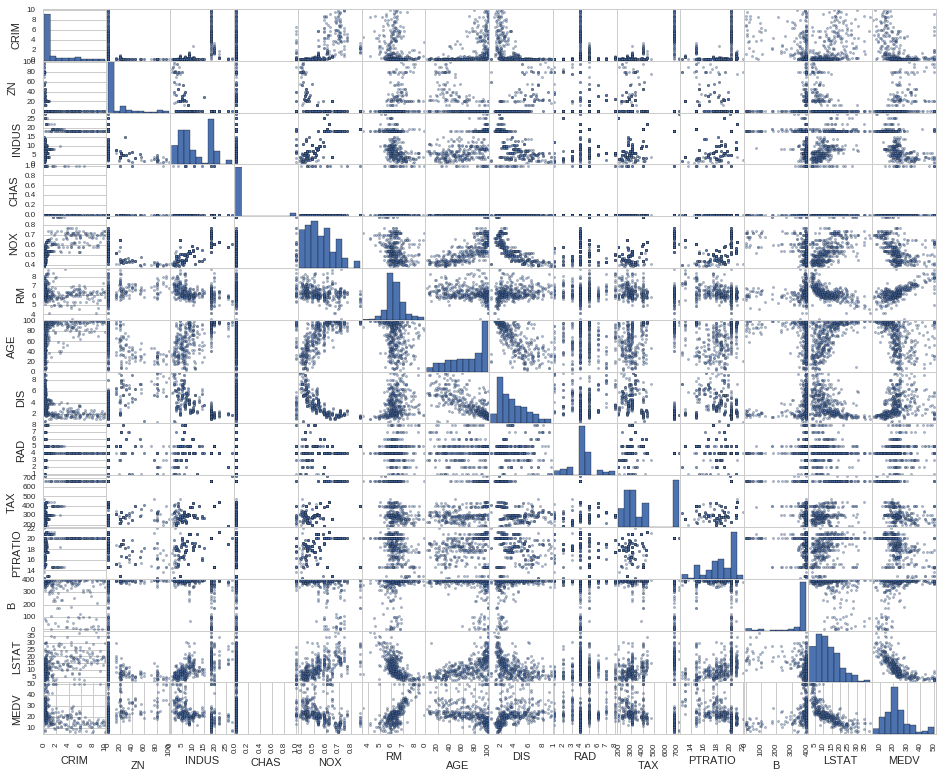

In [5]:
_ = pd.scatter_matrix(data_train.join(target_train))

----
## Developing a Model

### Performance Metric
First, we'll be defining a performance metric: [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>.

In [6]:
from sklearn.metrics import r2_score as performance_metric

----

## Analyzing Model Performance

### Learning Curves

Here we'll take advantage of some visualizations by Udacity:

> The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Overall, while a `DecisionTreeRegressor` was the given regressor originally chosen by Udacity. I've edited the function to allow for some custom regressors.

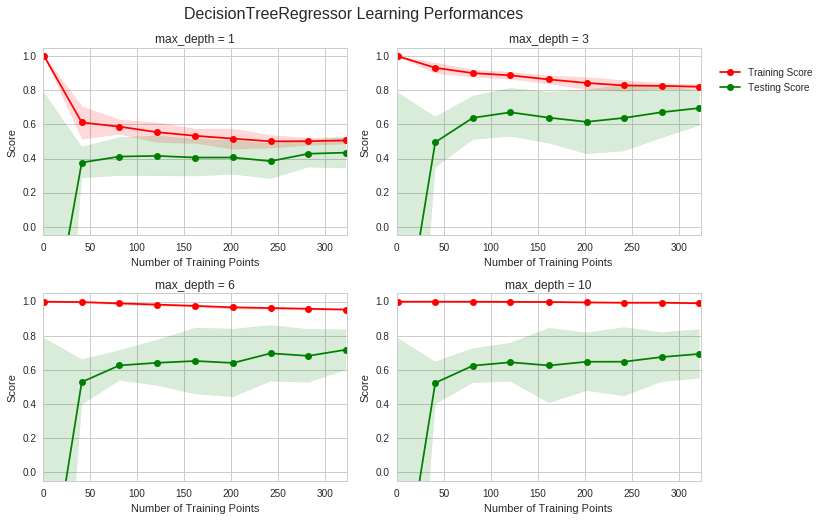

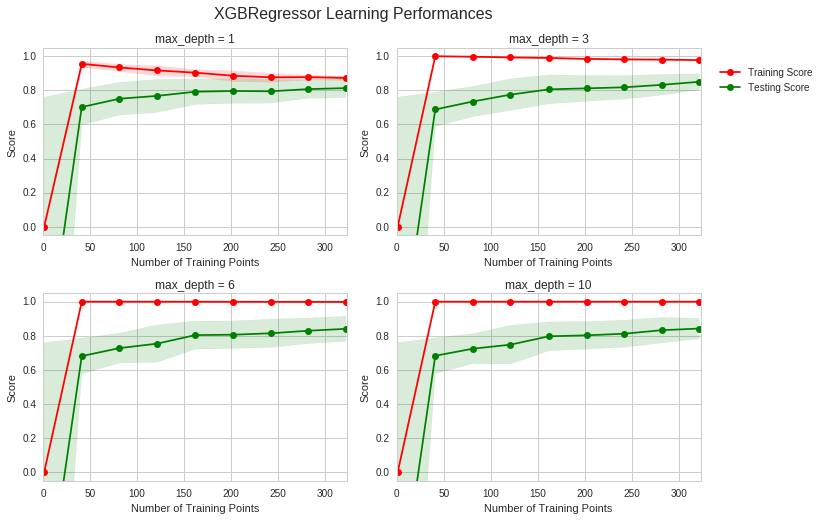

In [7]:
# Produce learning curves for varying training set sizes and maximum depths
import visuals as vs
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from functools import partial

GBRegressor = partial(XGBRegressor, seed=8329)

vs.ModelLearning(data_train, target_train, cls=DecisionTreeRegressor)
vs.ModelLearning(data_train, target_train, cls=GBRegressor)

### Learning the Data

<b>I would choose a Gradient Boosted Tree (XGBRegressor) with a max_depth of 3 here.</b> The reason being is that a max_depth of 3 or 6 seems to converge to the top score of .9. However, increasing max_depth adds complexity (model variance). We're better off choosing the simplest model that provides a good score. In this case, the lower max_depth of 3 at worse ties on score, but wins on lower complexity. This makes it the best candidate.

It's interesting to see that that Gradient Boosted Tree gets 100% accuracy on the train sets almost always except when the max depth is 1. Obviously a max depth of 1 is too highly biased, even for the much more complex Gradient Boosted Tree.

In all cases except the high bias case (max depth == 1), the models seem to continue benefitting from more data.

### Complexity Curves

Now let's focus most on the complexity now, rather than the sample size.

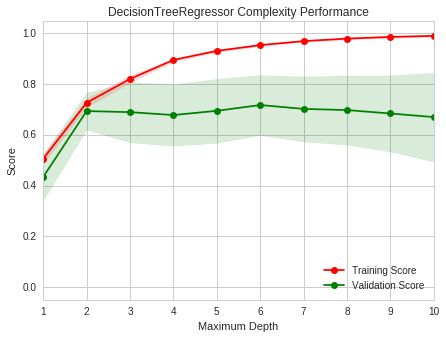

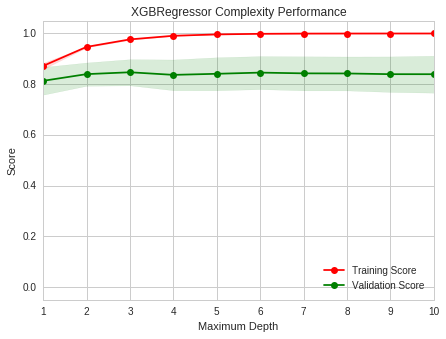

In [8]:
vs.ModelComplexity(data_train, target_train, cls=DecisionTreeRegressor)
vs.ModelComplexity(data_train, target_train, cls=GBRegressor)

### Bias-Variance Tradeoff

The model trained with a maximum depth of 1 seems to suffer from high bias. This can be identified by the fact that the training score is significantly lower than any other model configuration shown. A depth of one is equivalent to a single threshold, and in this case, the true relationship seems to be a bit more complex.

On the other hand, the model with a maximum depth of 10 seems to suffer from high complexity in the DecisionTree. This can be seen by the divergence between the training score and validation score, with the training score being much higher. As long as your model and fitting procedure is well defined, adding complexity should almost always allow a better training score. We see here though that the added complexity seems to produce worse performance on unseen data once you go beyond a maximum depth of 5. This is likely caused by the overly complex model fitting beyond the underlying relationship to fitting sample selection noise.

### Best-Guess Optimal Model

In this case, a maximum depth of 5 seems to produce the best validation score. This indicates it generalizes the best for the most important data-- data we haven't seen.

-----

## Evaluating Model Performance

### Grid Search

Grid search is a technique used to determine hyper-parameters-- in this case, maximum depth. It works by iterating through paramater candidates in a brute-force fashion, keeping the hyper-parameters with the best score. As we saw above, we selected the maximum depth based on the validation score, where the grid was a range between 1-10. The catch here is that now our validation score will likely exaggerate our out of sample score, since it was used to train our model (via hyper-parameters). We almost surely fit <i>some</i> noise related to the selection in our validation data that will not generalize. Still, this configuration is a good guess.

### Cross-Validation

K-fold cross-validation is very similiar to the cross-validation we did above. The difference is we use K unique subsets of the data for K train and validation dataset pairs. In finance, we might diversify risk (noise) by buying multiple seemingly independent stocks. Here we have K independent cross-validation samples, and thus average the sample selection noise towards zero to get a better estimate of our generalization error. We also now use the entire dataset to select hyper-parameters, which we can use to refit the model on the entire dataset (rather than just (K-1)/K of our data).

If we didn't use a cross-validation set at all, grid search would simply increase our model complexity without any sense of how well it is generalizing. Usually, the training score will increase and we would tend to select an overly complex model. Same as above, K-folds when used with grid search gives us a better estimate of the generalization error at each parameter setting, allowing us to better select the optimal model.

### Optimizing a Model

In [27]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Allows us to try random parameters in a log space
class LogspaceSampler:
    def __init__(self, min_val, max_val, seed):
        self.log_min_val = np.log(min_val)
        self.log_max_val = np.log(max_val)
        assert self.log_max_val > self.log_min_val
        self.log_spread = self.log_max_val - self.log_min_val
        self.random_state = np.random.RandomState(seed)

    def rvs(self):
        log_value = self.random_state.rand() * self.log_spread + self.log_min_val
        return np.exp(log_value)

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.20, random_state=28)

    # Create a Gradient Boosted regressor object
    regressor = GBRegressor()

    # Create a dictionary of parameter distributions to try
    params = {'max_depth': range(3, 7),
              'learning_rate': LogspaceSampler(0.01, 1.0, seed=29385),
              'gamma': LogspaceSampler(0.000001, 1.0, seed=46435),
              'reg_lambda': LogspaceSampler(0.000001, 1.0, seed=92385)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = RandomizedSearchCV(regressor, param_distributions=params, 
                              scoring=scoring_fnc, cv=cv_sets, n_iter=20)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Optimal Model

In [28]:
# Fit the training data to the model using grid search
reg = fit_model(data_train, target_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print reg

Parameter 'max_depth' is 6 for the optimal model.
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.5799748209284506e-06, learning_rate=0.055708473976272765,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='reg:linear', reg_alpha=0,
       reg_lambda=0.35799978506609781, scale_pos_weight=1, seed=8329,
       silent=True, subsample=1)


The RandomizedSearchCV picked the same model we picked, with a maximum depth of 6. This is the model that maximized the validation score.

### Predicting Selling Prices

Finally!

It does a bit worse than I'd hoped (R2 of .82). If I was to use this model for clients, I'd need some measure of the prediction error. Obviously, I can calculate this on the out of sample predictions. However, something worth noting is that it's likely that the standard deviation of home prices increases with the home price itself. Personally, I'd expect standard deviation to be a % of the price, similiar to that observed in stock prices (Hull, 1997). We'll check this next...

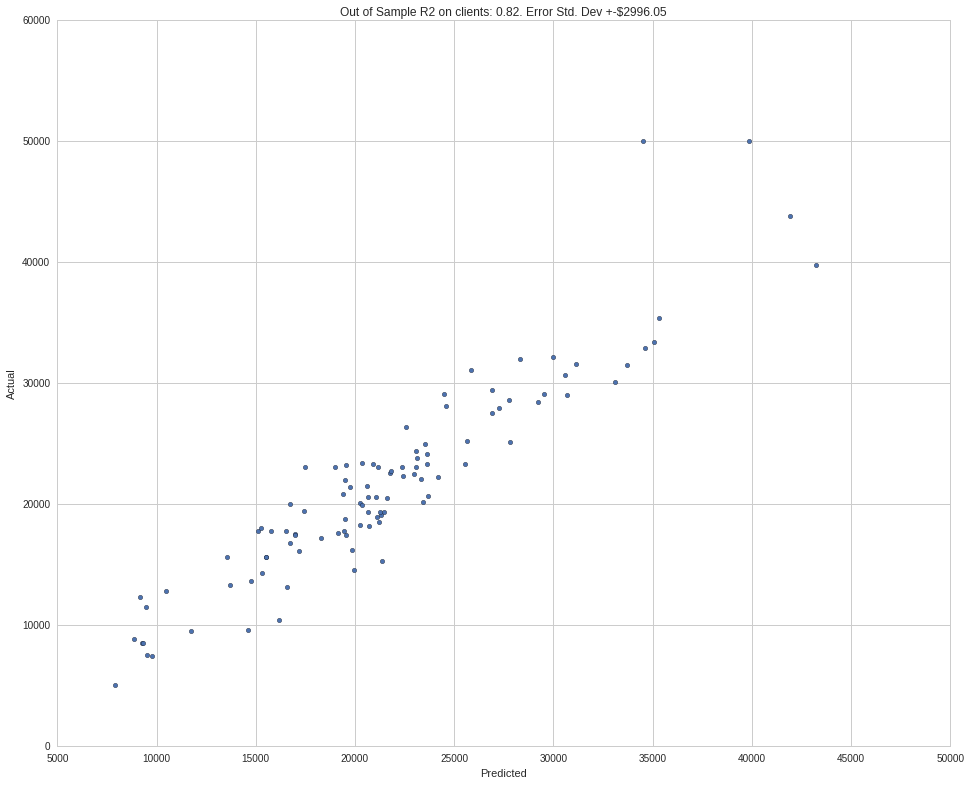

In [29]:
# Produce a matrix for client data
client_data = data_test

predictions = pd.DataFrame(dict(
    Actual=target_test * 1000.,
    Predicted=reg.predict(client_data) * 1000.,
))

r2 = performance_metric(predictions.Predicted, predictions.Actual)
errors = (predictions.Actual - predictions.Predicted)
error = errors.std()

predictions.plot.scatter(x='Predicted', y='Actual', title='Out of Sample R2 on clients: %.2f. Error Std. Dev +-$%.2f' % (
        r2, error,
))

### |error| as a function of price

I'm surprised to see there doesn't seem to be a significant slope here, thus the error actually does not seem to be related to the price. 

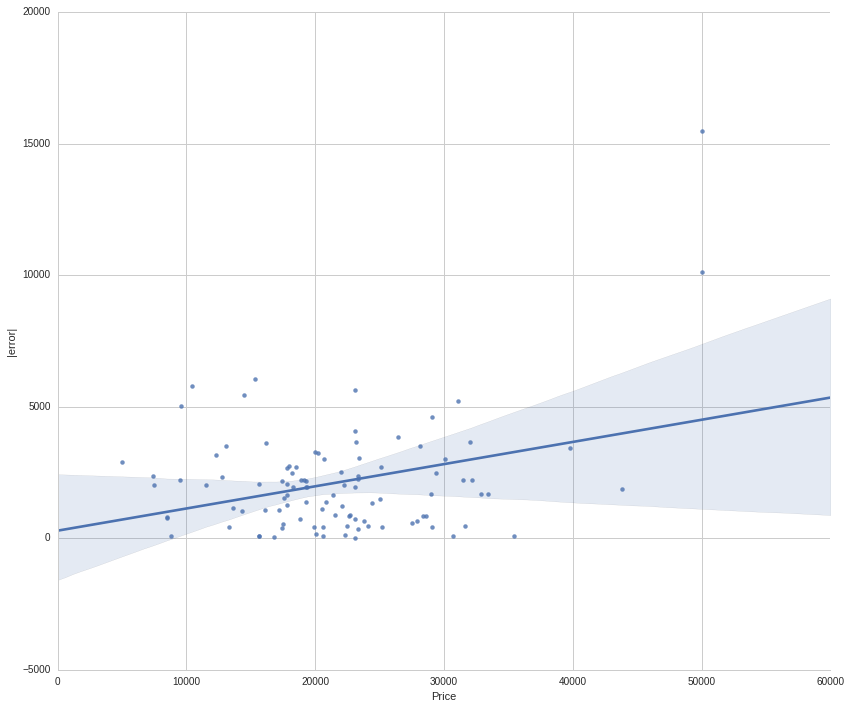

In [30]:
error_data = pd.DataFrame({'|error|': np.abs(errors), 'Price': target_test * 1000})
sns.lmplot(data=error_data, x='Price', y='|error|', size=10, aspect=1.2)

Just to double check, we'll take a look at the absolute % errors as a function of the price. Again it seems to be the case that the relative error is much higher on low prices homes, consistent with a $standard error that is unaffected by price.

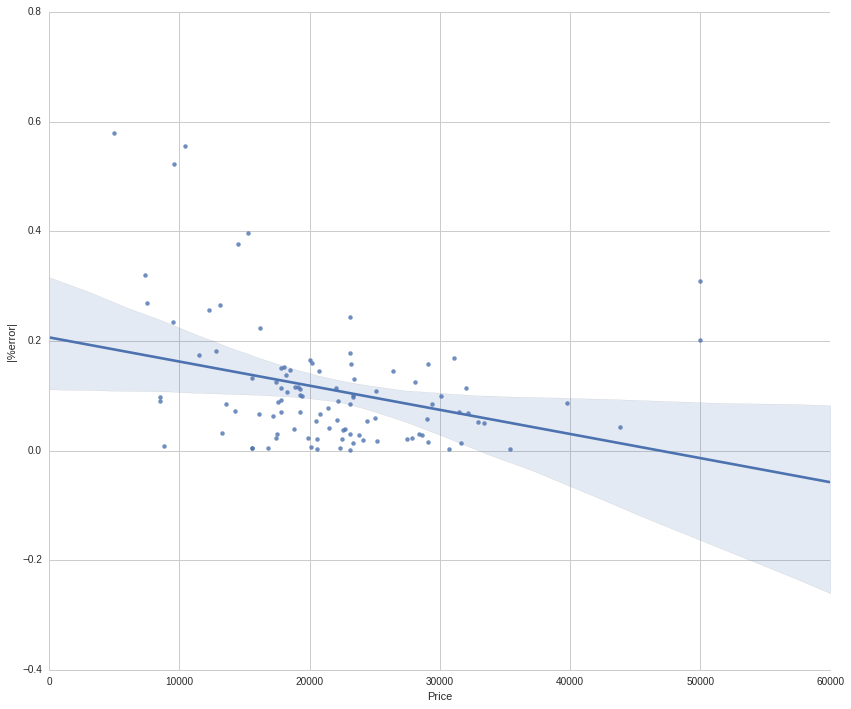

In [34]:
error_data['|%error|'] = error_data['|error|'] / error_data.Price
sns.lmplot(data=error_data, x='Price', y='|%error|', size=10, aspect=1.2)

# Visualizing the error distribution

Despite only achieving an R2 of around 0.82 out of sample, the standard error is fairly low, and while the error distribution seems to be non-normal at the tails (excess kurtosis and skew), 90% of the time, we were within $4100 of the price. That's not too bad assuming you're living on the upper quantile. I'd be OK with a realtor that starts out with a price within 20% of the actual selling price, 90% of the time. However, the model won't be very helpful for the lower priced homes. 

Intuitively, this could be explained by the fact that low priced neighborhoods may be low priced for reasons other than the usual suspects (used as factors here). The same applies to higher priced neighborhoods, but since they are higher priced, potentially the error is less of an issue.

Error 5% quantile: $-3484.98
Error 95% quantile: $4076.90


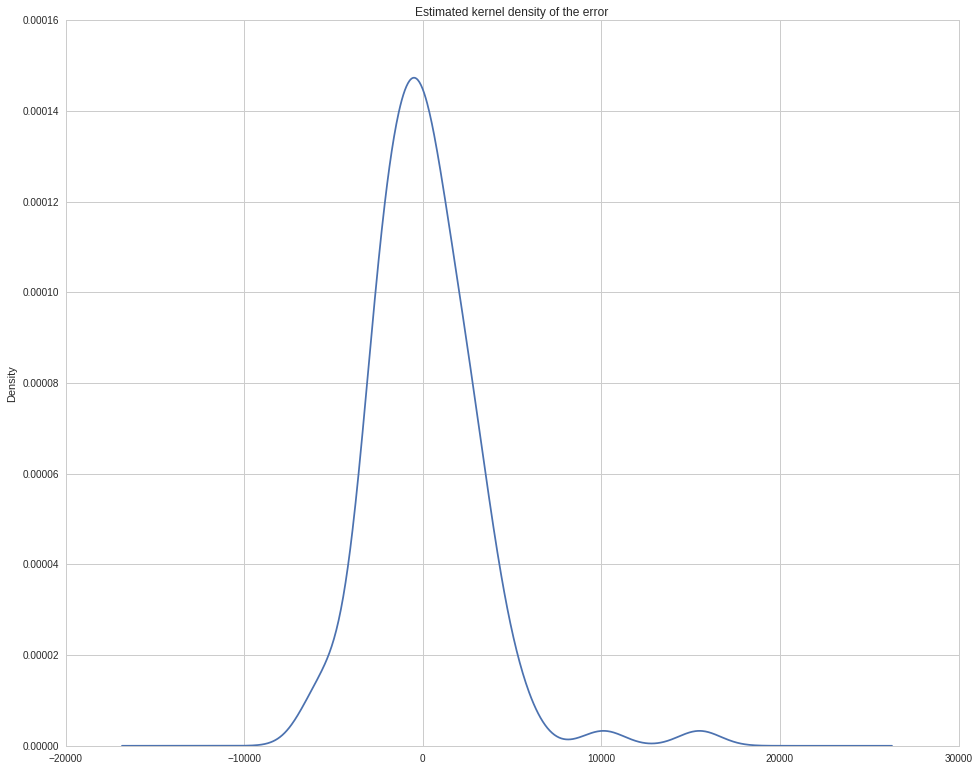

In [45]:
print("Error 5%% quantile: $%.2f" % (errors.quantile(.05)))
print("Error 95%% quantile: $%.2f" % (errors.quantile(.95)))
errors.plot.kde(title='Estimated kernel density of the error')

# What's driving our model?

For the most part, I've really relied (perhaps too much) on the data to determine our model. I didn't remove any factors. I also didn't do any kinds of factor decompositions or scaling. In terms of scaling, Tree models are effectively invariant so this is ok. Also, while more factors increases the combinations tree models can search, I'm applying some L2 regularization on the model that discourages the model from becoming too complex. 

Still, it likely would have been fruitful to do a bit more introspection on the factors before fitting the model, but alas it's too late. We've seen the test set. 

Instead, let's take a look at what factors our model determined to be most important.

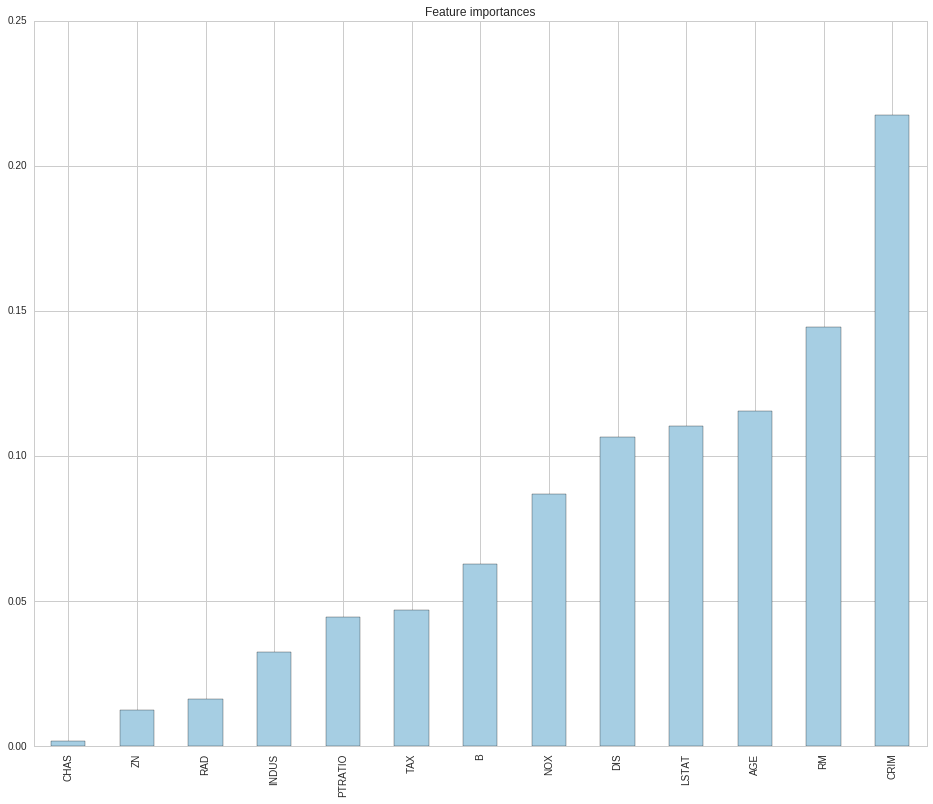

In [55]:
feature_importances = pd.Series(reg.booster().get_fscore())
feature_importances = feature_importances / feature_importances.sum()
feature_importances.sort_values().plot.bar(colormap='Paired', title='Feature importances')

Unsurprisingly, crime is one of the biggest factors in the price of a home, followed by the number of rooms, and age. The Charles River dummy variable likely only explained only very tiny proportion the samples. The proportion of residential zoning `ZN` and radius to major transportation `RAD` were fairly unimportant. I was fairly surprised that `PTRATIO` (teacher to student ratio) wasn't a bigger factor. Education seems to be a huge factor in the NYC region, but perhaps `PTRATIO` is not a great proxy or preference have changed over time.

### Applicability

Overall, I would not suggest using a model fit on data from 1978 to predict prices 40 years later due to relative changes in preferences. For example, fewer people in the current generation are deciding to get married and have kids, likely reducing the preference for more rooms and low student teacher ratios. 

Further, the Boston market is very different from the Lincoln, NE market for example. People in these two markets have different careers, lifestyles, values, and preferences, and this is the case for most cities. Each is potentially unique.

Today, we have much more data available related to the types of surrounding businesses, transportation, employment centers as well as peoples reactions and reviews to those places. I think the factors used serve as a good starting point for residential prices, but I think a more modern model would likely do much better. I'd love to know Zillow's standard error on selling prices.